### Advanced PyTorch Image Classification with MLflow Logging and Feature Storage


This notebook builds an image classification pipeline using a real-world flower dataset with:
- Transfer Learning (ResNet18)
- MLflow for experiment tracking
- Feature extraction and logging
- Confusion matrix and evaluation


### ✅ SECTION 1: Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import mlflow
import mlflow.pytorch

/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


### ✅ Reproducibility setup

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cpu


### ✅ SECTION 2: Load Real-World Dataset (manually downloaded)
- Dataset source: https://www.kaggle.com/code/gallo33henrique/flowers-recognition-cnn
- Expected structure: data/flowers/train and data/flowers/val

In [3]:
import os
import shutil
import random

def split_dataset_once(original_path, train_path, val_path, split_ratio=0.8):
    # Safety check: original_path should contain class folders, not already be 'train' or 'val'
    sample_subfolder = next(os.walk(original_path))[1]
    if 'train' in sample_subfolder or 'val' in sample_subfolder:
        raise ValueError("⚠️ Your 'original_path' should point to the folder containing class folders (like daisy/, rose/), NOT to train/ or val/.")

    if os.path.exists(train_path) and os.listdir(train_path) and os.path.exists(val_path) and os.listdir(val_path):
        print("✅ Dataset already split. Skipping.")
        return

    print("🚀 Splitting dataset...")

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)

    for category in os.listdir(original_path):
        cat_path = os.path.join(original_path, category)
        if not os.path.isdir(cat_path):
            continue

        images = [img for img in os.listdir(cat_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        split = int(len(images) * split_ratio)

        train_imgs = images[:split]
        val_imgs = images[split:]

        for phase, img_list in zip([train_path, val_path], [train_imgs, val_imgs]):
            os.makedirs(os.path.join(phase, category), exist_ok=True)
            for img in img_list:
                src = os.path.join(cat_path, img)
                dst = os.path.join(phase, category, img)
                if not os.path.exists(dst):
                    shutil.copy(src, dst)

    print("✅ Done. Dataset split into:")
    print(f" - Train: {train_path}")
    print(f" - Val: {val_path}")

# Example usage
original_path = 'flowers'  # Where daisy/, rose/, etc. exist
train_path = 'data/flowers_split/train'
val_path = 'data/flowers_split/val'

split_dataset_once(original_path, train_path, val_path)


✅ Dataset already split. Skipping.


In [4]:
data_dir = "data/flowers_split"
if not os.path.exists(data_dir):
    raise Exception("Please download and unzip the dataset into 'data/flowers' directory")

transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


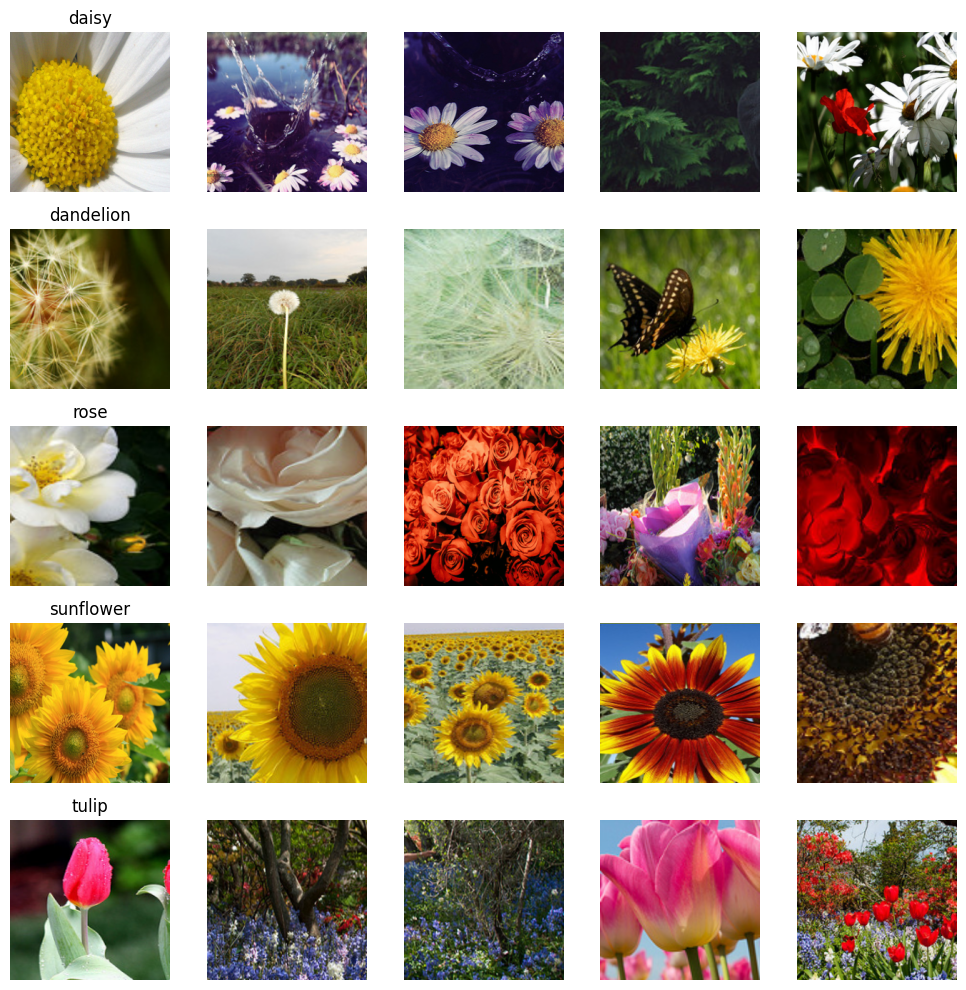

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Helper: unnormalize tensor image for display
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # convert from Tensor format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # de-normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Visualize 5 random images from each class
def show_class_samples(dataset, class_names, samples_per_class=5):
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_samples = {k: [] for k in class_names}

    # Collect samples for each class
    for img, label in dataset.samples:
        class_name = idx_to_class[label]
        if len(class_samples[class_name]) < samples_per_class:
            class_samples[class_name].append(img)

        # Stop early if all filled
        if all(len(v) == samples_per_class for v in class_samples.values()):
            break

    # Plot
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))
    for row_idx, class_name in enumerate(class_names):
        for col_idx, img_path in enumerate(class_samples[class_name]):
            img = dataset.loader(img_path)
            img = dataset.transform(img)
            plt.subplot(len(class_names), samples_per_class, row_idx * samples_per_class + col_idx + 1)
            imshow(img, title=class_name if col_idx == 0 else None)
    plt.tight_layout()
    plt.show()

# Call this with your training dataset
show_class_samples(image_datasets['train'], class_names)


### ✅ SECTION 3: Define Transfer Learning Model (ResNet18)

In [6]:
model = models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
print(model)

/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kasimajji/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### ✅ SECTION 4: Setup Loss, Optimizer, Scheduler

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### ✅ SECTION 5: Training Loop with MLflow Logging

In [8]:
mlflow.set_experiment("Flower_Classification_ResNet")
best_model_wts = model.state_dict()
best_acc = 0.0
train_history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

with mlflow.start_run():
    mlflow.log_param("model", "resnet18")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("lr", 0.001)

    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        print("-" * 20)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_history['train_loss'].append(epoch_loss)
            else:
                train_history['val_loss'].append(epoch_loss)
                train_history['val_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)
            if phase == 'val':
                mlflow.log_metric("val_accuracy", epoch_acc.item(), step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

        scheduler.step()

    model.load_state_dict(best_model_wts)
    mlflow.pytorch.log_model(model, "best_model")

Epoch 1/10
--------------------
train Loss: 0.9190 Acc: 0.6729
val Loss: 0.5280 Acc: 0.8370
Epoch 2/10
--------------------
train Loss: 0.5479 Acc: 0.8181
val Loss: 0.4307 Acc: 0.8601
Epoch 3/10
--------------------
train Loss: 0.4782 Acc: 0.8323
val Loss: 0.3968 Acc: 0.8694
Epoch 4/10
--------------------
train Loss: 0.4526 Acc: 0.8369
val Loss: 0.3634 Acc: 0.8705
Epoch 5/10
--------------------
train Loss: 0.4513 Acc: 0.8386
val Loss: 0.3617 Acc: 0.8763
Epoch 6/10
--------------------
train Loss: 0.4183 Acc: 0.8534
val Loss: 0.3598 Acc: 0.8798
Epoch 7/10
--------------------
train Loss: 0.4062 Acc: 0.8563
val Loss: 0.3433 Acc: 0.8832
Epoch 8/10
--------------------
train Loss: 0.3715 Acc: 0.8679
val Loss: 0.3380 Acc: 0.8832
Epoch 9/10
--------------------
train Loss: 0.3903 Acc: 0.8592
val Loss: 0.3350 Acc: 0.8879
Epoch 10/10
--------------------
train Loss: 0.3863 Acc: 0.8685
val Loss: 0.3367 Acc: 0.8913


### ✅ SECTION 6: Feature Extraction and Save

In [11]:
model.eval()
feature_store = []
model.eval()

with torch.no_grad():
    for inputs, _ in dataloaders['val']:
        inputs = inputs.to(device)

        # Extract features using full forward pass up to avgpool
        x = model.conv1(inputs)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)

        # Flatten consistently: from [B, C, 1, 1] to [B, C]
        features = x.view(x.size(0), -1)

        feature_store.append(features.cpu().numpy())

# Now it's safe to concatenate
feature_array = np.concatenate(feature_store, axis=0)
os.makedirs("outputs", exist_ok=True)
np.save("outputs/features.npy", feature_array)
print(f"✅ Feature array saved: shape {feature_array.shape}")

mlflow.log_artifact("outputs/features.npy")
print("✅ Features saved.")

✅ Feature array saved: shape (865, 512)
✅ Features saved.


### ✅ SECTION 7: Evaluation

              precision    recall  f1-score   support

       daisy       0.94      0.86      0.90       153
   dandelion       0.88      0.93      0.91       211
        rose       0.88      0.85      0.86       157
   sunflower       0.91      0.91      0.91       147
       tulip       0.87      0.89      0.88       197

    accuracy                           0.89       865
   macro avg       0.90      0.89      0.89       865
weighted avg       0.89      0.89      0.89       865



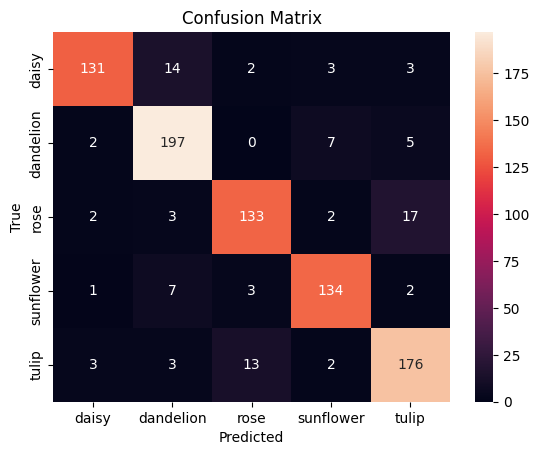

In [12]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("outputs/confusion_matrix.png")
mlflow.log_artifact("outputs/confusion_matrix.png")
plt.show()

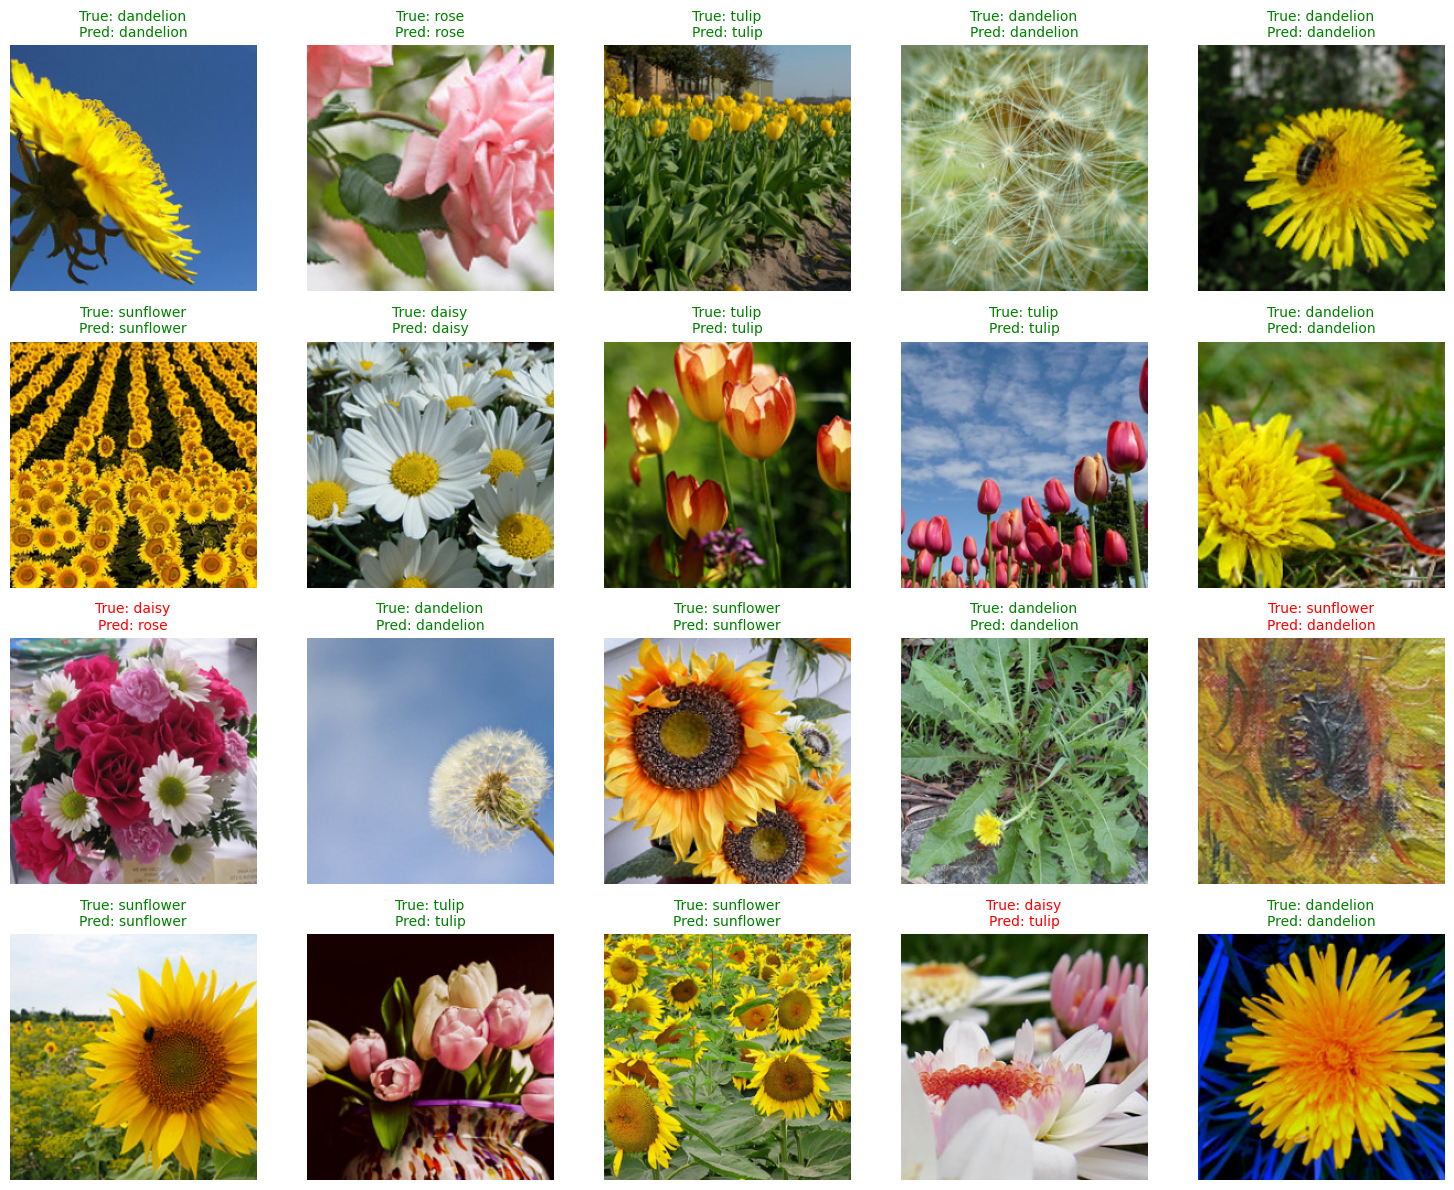

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Helper to denormalize and display an image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Function to show a grid of predictions vs ground truth
def show_predictions_grid(model, dataloader, class_names, device, num_images=20):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, int(num_images / 5) * 3))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                ax = plt.subplot(int(num_images / 5), 5, images_shown + 1)
                img = imshow(inputs[i].cpu())
                plt.imshow(img)
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]

                color = "green" if true_label == pred_label else "red"
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
                ax.axis("off")

                images_shown += 1

# Example usage after evaluation
show_predictions_grid(model, dataloaders['val'], class_names, device, num_images=20)


### ✅ SECTION 8: Training History Visualization

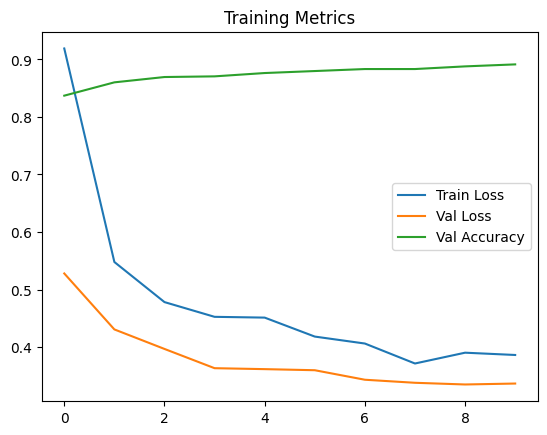

In [14]:
plt.plot(train_history['train_loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Val Loss')
plt.plot(train_history['val_acc'], label='Val Accuracy')
plt.legend()
plt.title("Training Metrics")
plt.savefig("outputs/training_plot.png")
mlflow.log_artifact("outputs/training_plot.png")
plt.show()


### ✅ Summary: Best Practices Demonstrated
- Transfer learning with ResNet
- MLflow experiment tracking (params, metrics, models, artifacts)
- Manual feature storage for downstream use
- Data augmentation, reproducibility setup
- Training/validation loops with scheduler
- Visualizations for training metrics
- Confusion matrix and classification report